In [252]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline
plt.rcParams["figure.dpi"] = 200
plt.rcParams["figure.figsize"] = (5 * (1 + np.sqrt(5)), 10)

In [223]:
train = pd.read_csv("train.csv") #Model train data
test = pd.read_csv("test.csv")   #Model test data


#Remaps Sex columns to binary map
genderDic =  {'female': 0, 'male': 1}
train['Sex'] = train['Sex'].map(genderDic).astype(int)
test['Sex'] = test['Sex'].map( genderDic).astype(int)

pclasses = train.Pclass.value_counts().index.tolist() #List with all the Pclasses, in this case [1, 2, 3], sort by counts

#Sets the null ages with the mean age of the Pclass and the gender
train['AgeIsNull'] = train["Age"].isnull().astype(int) #Saves the null entries, would not be necessary
for sex in genderDic.values():  #0 or 1
    for pclass in pclasses: #1, 2, 3
        mean = train[(train.Sex == sex) & (train.Pclass == pclass)].Age.dropna().median()
        train.loc[(train.Age.isnull()) & (train.Sex == sex) & (train.Pclass == pclass), 'Age'] = mean
        mean = test[(test.Sex == sex) & (test.Pclass == pclass)].Age.dropna().median()
        test.loc[(test.Age.isnull()) & (test.Sex == sex) & (test.Pclass == pclass), "Age"] = mean

        
if len(test["Fare"][ test["Fare"].isnull() ]) > 0:
    median_fare = np.zeros(3)
    for f in pclasses:                                              
        median_fare = test[ test.Pclass == f]['Fare'].dropna().median()                                           
        test.loc[ (test.Fare.isnull()) & (test.Pclass == f ), 'Fare'] = median_fare
train['FamilySize'] = train['SibSp'] + train['Parch']
test['FamilySize'] = test['SibSp'] + test['Parch']


<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null int32
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           418 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int32(1), int64(4), object(4)
memory usage: 37.6+ KB


C:\Users\sadeus\Anaconda3\lib\site-packages\matplotlib\__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


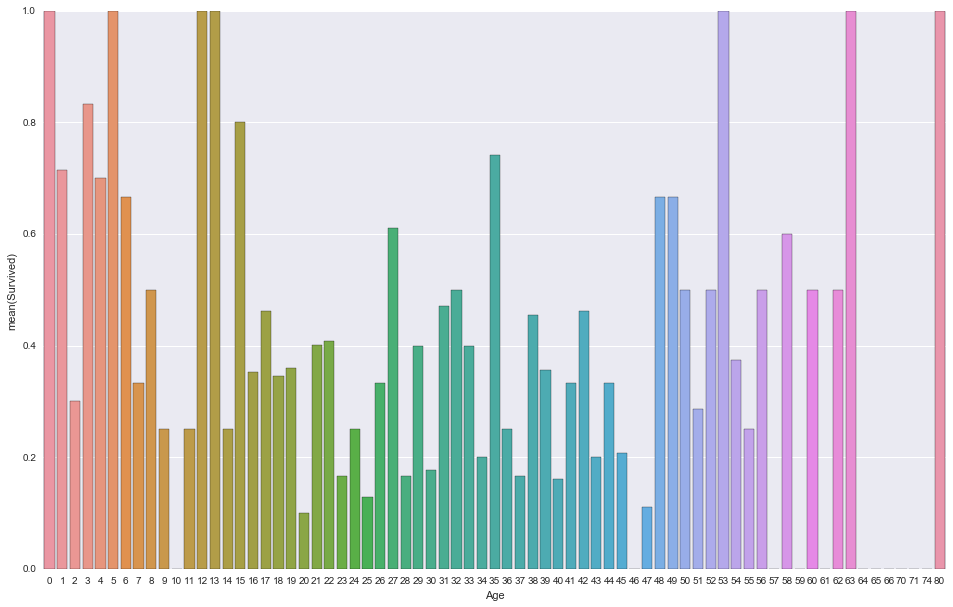

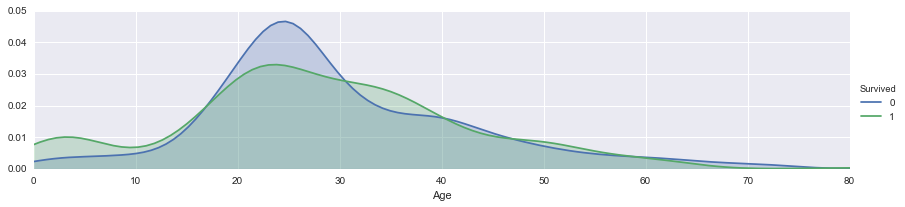

In [253]:
#We plot the mean of survives by age
average_age = train[["Age", "Survived"]].groupby(['Age'],as_index=False).mean()
average_age["Age"] = average_age["Age"].astype(int)
sns.barplot(x='Age', y='Survived', data=average_age, ci=None);

#Creates a smooth curve with 
facet = sns.FacetGrid(train, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()

In [198]:
#Gets the proportion of the sample size which have Cabin entry not null (created in this particular cell), group by Survivor
#Shows if the Cabin information is relevant for an analysis, 
#or insted is biased by the take of data (in this case, of the survivors vs the manifest of the ship)
#If the result is near 1 is likely that the manifest has no ubication in the ship of the passangers.
cabin = train[["Survived", "Cabin"]].copy()
cabin["CabinIsNull"] = cabin["Cabin"].isnull().astype(int)
cabin[["Survived","CabinIsNull"]].groupby("Survived").mean()

#The result shows that the Cabin information is not meaningfull, biased by the data of the survivors.

,CabinIsNull
Survived,
0,0.876138
1,0.602339


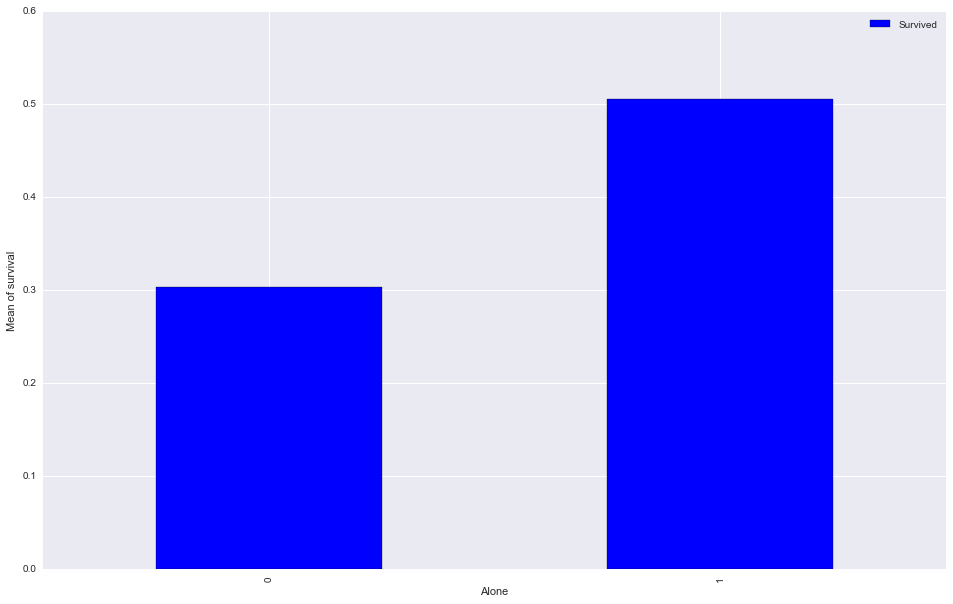

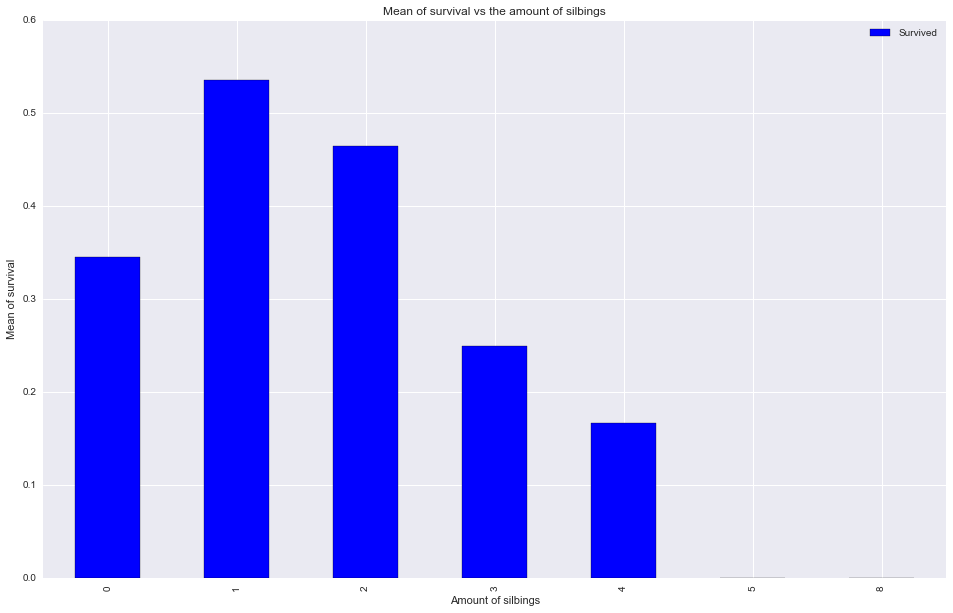

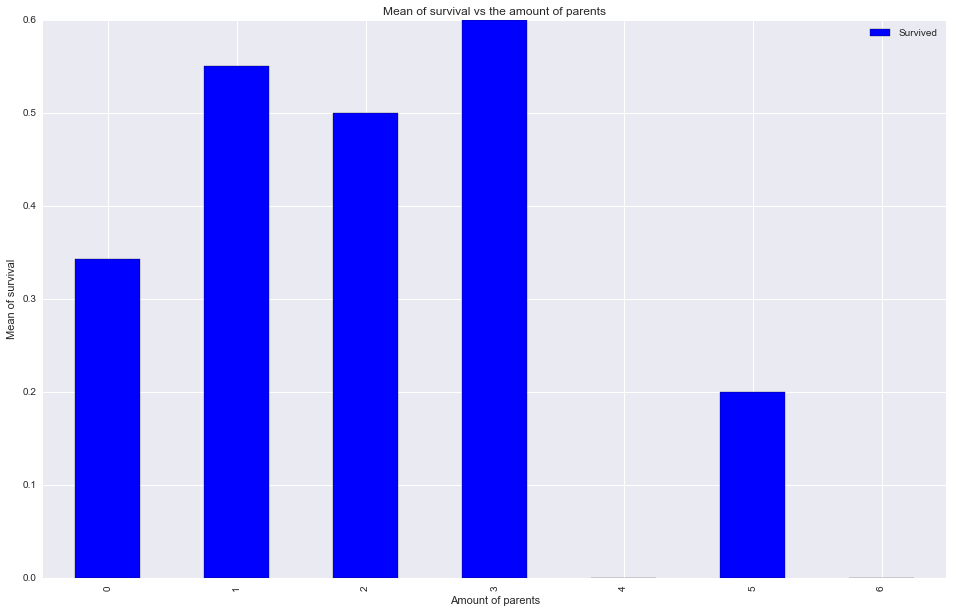

In [272]:
#In this section, we search the chance of survival versus the family size
family = train[["Survived", "SibSp", "Parch", "Sex"]].copy()
family['FamilySize'] = family['SibSp'] + family['Parch']
family["Alone"] = family["FamilySize"].map(lambda x: x != 0).astype(int)

family.groupby("Alone", as_index= False).mean().plot(x="Alone",y="Survived", kind="bar")
plt.xlabel("Alone")
plt.ylabel("Mean of survival")

g = sns.FacetGrid(pd.melt(df, id_vars='b'), col='b')

family.groupby("SibSp", as_index= False).mean().plot(x="SibSp",y="Survived", kind="bar")
plt.xlabel("Amount of silbings")
plt.ylabel("Mean of survival")
plt.title("Mean of survival vs the amount of silbings")

family.groupby("Parch", as_index= False).mean().plot(x="Parch",y="Survived", kind="bar")
plt.xlabel("Amount of parents")
plt.ylabel("Mean of survival")
plt.title("Mean of survival vs the amount of parents")

In [211]:
#This is the actual modeling
#In this case the classifier used is a Random Forest, 
#which tries to capture the relations of the data non parametric ways
#with a number of decision forests (a number that can be changed)

#First of all, we drop the features with object type, in this case these features are strings
dropFeatures = train.dtypes[train.dtypes.map(lambda x: x=='object')].index.tolist()

#In the train set we create a CabinIsNull to get some insight of the data. 
#We don't want that feature as an input
train = train.drop(dropFeatures, axis=1)
test = test.drop(dropFeatures, axis=1)


X = train[train.columns[2:]]
print(X.info())
print(test.info())
Xtest = test
y = train["Survived"]
model = RandomForestClassifier()
model.fit(X, y)
model.score(X, y)
Ypred = model.predict(Xtest)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 7 columns):
Pclass       891 non-null int64
Sex          891 non-null int32
Age          891 non-null float64
SibSp        891 non-null int64
Parch        891 non-null int64
Fare         891 non-null float64
AgeIsNull    891 non-null int32
dtypes: float64(2), int32(2), int64(3)
memory usage: 48.7 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 7 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Sex            418 non-null int32
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Fare           418 non-null float64
dtypes: float64(2), int32(1), int64(4)
memory usage: 24.5 KB
None


C:\Users\sadeus\Anaconda3\lib\site-packages\sklearn\base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
C:\Users\sadeus\Anaconda3\lib\site-packages\sklearn\base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
C:\Users\sadeus\Anaconda3\lib\site-packages\sklearn\base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
C:\Users\sadeus\Anaconda3\lib\site-packages\sklearn\base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
C:\Users\sadeus\Anaconda3\lib\site-packages\sklearn\base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, var

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

,CabinIsNull
Survived,
0,0.876138
1,0.602339


In [163]:
submission = pd.DataFrame({"PassengerId": test["PassengerId"],"Survived": Ypred})
submission.to_csv('submission.csv', index=False)
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,0
7,899,0
8,900,0
9,901,0


In [201]:
for i, d in {1: "3", 2:"5"}:
    print(i, d)

TypeError: 'int' object is not iterable

[3, 1, 2]